# Titanic Dataset Big Data Pipeline
This notebook demonstrates a full big data pipeline using PySpark for the Titanic dataset, including data preprocessing, visualization, and training a classification model.

In [10]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 15.3 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("TitanicPipeline") \
    .getOrCreate()

# Load the Titanic dataset
df = spark.read.csv("titanic.csv", header=True, inferSchema=True)
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/12 14:22:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+
|pclass|survival|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|
|     1|       0|Allison, Mrs. Hud...|female|  25.0|    1|    2|113781|  151.55|C22 C26|       S|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+
only showing top 5 rows



## Data Preprocessing
Handle missing values and perform feature engineering.

In [19]:
from pyspark.sql.functions import col

# Handle missing values
df = df.fillna({"age": df.select("age").dropna().rdd.map(lambda x: x[0]).mean()})
df = df.dropna(subset=["Embarked"])

# Feature Engineering
from pyspark.ml.feature import StringIndexer, VectorAssembler

sex_indexer = StringIndexer(inputCol="sex", outputCol="sexIndex")
embarked_indexer = StringIndexer(inputCol="embarked", outputCol="embarkedIndex")
df = sex_indexer.fit(df).transform(df)
df = embarked_indexer.fit(df).transform(df)
df.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+--------+-------------+
|pclass|survival|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|sexIndex|embarkedIndex|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+--------+-------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|     1.0|          0.0|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|     0.0|          0.0|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|     1.0|          0.0|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|     0.0|          0.0|
|     1|       0|Allison, Mrs. Hud...|female|  25.0|    1|    2|113781|  151.55|C22 C26|       S|     1.0|          0.0|
+------+--------+---------------

In [20]:
# Selecting the features
assembler = VectorAssembler(inputCols=["pclass", "age", "fare", "sexIndex", "embarkedIndex"],
                            outputCol="features", handleInvalid="skip") # avoid handleInvalid="skip". It is prefered to have a look at your data and decide how to handle ALL the missing values
df = assembler.transform(df)
df.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+--------+-------------+--------------------+
|pclass|survival|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|sexIndex|embarkedIndex|            features|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+--------+-------------+--------------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|     1.0|          0.0|[1.0,29.0,211.337...|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|     0.0|          0.0|[1.0,0.9167,151.5...|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|     1.0|          0.0|[1.0,2.0,151.55,1...|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|     0.0|          0.0|[1.0,30.0,151.55,...|
|     

## Data Visualization
Convert Spark DataFrame to Pandas for visualization.

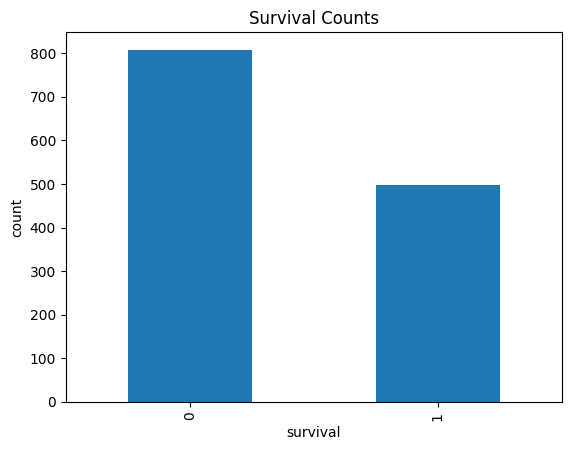

In [21]:
import matplotlib.pyplot as plt

pandas_df = df.toPandas()
pandas_df['survival'].value_counts().plot(kind='bar')
plt.title("Survival Counts")
plt.xlabel("survival")
plt.ylabel("count")
plt.show()

## Train a Classification Model
Split the data into training and testing sets, and train a logistic regression model.

In [22]:
# Split the dataset
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression Model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="survival")
model = lr.fit(train)
predictions = model.transform(test)
predictions.select("survival", "prediction").show(5)

24/12/12 14:14:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/12 14:14:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+--------+----------+
|survival|prediction|
+--------+----------+
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 5 rows



## Model Evaluation
Evaluate the logistic regression model.

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="survival", rawPredictionCol="prediction")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7421881407364881
